# Test Best Models

Test notebook to generate the statistics of the different models found with AMS. First load the required libraries

In [1]:
import datetime
import logging
import sys
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K
from keras.models import model_from_json

from sklearn.model_selection import KFold
from scipy import stats

#sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
sys.path.append('/media/controlslab/DATA/Projects')

import ann_framework.aux_functions as aux_functions

import automatic_model_selection
from automatic_model_selection import Configuration
from ann_encoding_rules import Layers
import fetch_to_keras
#from CMAPSAuxFunctions import TrainValTensorBoard

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression, SequenceTunableModelClassification

#Data handlers
from ann_framework.data_handlers.data_handler_CMAPSS import CMAPSSDataHandler
from ann_framework.data_handlers.data_handler_MNIST import MNISTDataHandler
from ann_framework.data_handlers.data_handler_CIFAR10 import CIFAR10DataHandler

Using TensorFlow backend.


### Given a model, get the compiled model

In [2]:
def get_compiled_model(model, problem_type, optimizer_params=[]):
    """Obtain a keras compiled model"""
    
    #Shared parameters for the models
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    
    return model


def create_tunable_model(model_genotype, problem_type, input_shape, data_handler, model_number):
    
    K.clear_session()
    
    model = fetch_to_keras.decode_genotype(model_genotype, problem_type, input_shape, 1)
    
    model = get_compiled_model(model, problem_type, optimizer_params=[])
    
    if problem_type == 1:
        tModel = SequenceTunableModelRegression('ModelReg_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
    else:
        tModel = SequenceTunableModelClassification('ModelClass_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
        
    return tModel

### Load cmaps data handler

In [3]:
def cmapss_dhandler(data_scaler=None):

    #Selected as per CNN paper
    features = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 
    'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
    selected_indices = np.array([2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21])
    selected_features = list(features[i] for i in selected_indices-1)
    data_folder = '../CMAPSSData'

    window_size = 24
    window_stride = 1
    max_rul = 129

    dhandler_cmapss = CMAPSSDataHandler(data_folder, 1, selected_features,
                                       max_rul, window_size, window_stride, data_scaler=data_scaler)

    input_shape = (len(selected_features)*window_size, )

    return dhandler_cmapss

### Load models and evaluate model

In [4]:
def load_model(model_file, weights_file="", problem_type=1):
    
    p_type = ""
    
    # load json and create model
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    print("Loaded model from disk") 
        
    #Load weights if specified
    if weights_file != "":
        # load weights into new model
        loaded_model.load_weights(weights_file)
        print("Loaded weights from disk") 
    else:
        print("Model needs training")
        
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        p_type = "regression"
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        p_type = "classification"
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    print("Created model for " + p_type + " with loss function " + lossFunction)

    return loaded_model
        
        

### Load each of the models and test them

In [5]:
best_model_folder = 'best_models'
"""
test_sets = {'cifar10':(CIFAR10DataHandler, None, 2), 
             'cmapss':(cmaps_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1), 
             'mnist':(MNISTDataHandler, None, 2)}
"""

test_sets = {'cmapss':(cmapss_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1)}
#test_sets = {'mnist':(MNISTDataHandler, None, 2)}
#alpha_folders = ['alpha0.6', 'alpha0.8', 'alpha1']
#alpha_folders = ['alpha0.5']
#alpha_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

results = {}

k = 5  #For 5-fold cross validation
evaluations_cv = np.zeros(k)
evaluations_test = np.zeros(k)

In [6]:
alpha_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
#alpha_values = [0.4]

for dataset in test_sets.keys():
    for alphaValue in alpha_values:
        
        model_file_name = 'yulin/alpha{}/bestModel_global.json'.format(alphaValue)
        weights_file_name = 'yulin/alpha{}/bestModel_global.h5'.format(alphaValue)
        trainable_count = 0
        
        print("Testing for "+model_file_name)
        
        results_key = dataset + "_" +  str(alphaValue)
        
        model_location = best_model_folder + '/' + dataset + '/' + model_file_name
        
        if weights_file_name != "":
            weights_location = best_model_folder + '/' + dataset + '/' + weights_file_name
        
        dhandler, data_scaler, problem_type = test_sets[dataset]

        #model = load_model(model_location, weights_location, problem_type)   
        
        data_handler = dhandler(data_scaler=data_scaler)
        data_handler.load_data(verbose = 1, unroll=True)
        data_handler.print_data()
        
        folds = list(KFold(n_splits=k, shuffle=True).split(data_handler.X_train))
        
        print('Validation on model:' + model_location)
        
        for j, (train_idx, val_idx) in enumerate(folds):

            print('\nExperiment on Fold ', j)
            
            K.clear_session()  #Clear the previous tensorflow graph 

            X_train_cv = data_handler.X_train[train_idx]
            y_train_cv = data_handler.y_train[train_idx]
            X_valid_cv = data_handler.X_train[val_idx]
            y_valid_cv = data_handler.y_train[val_idx]

            model = load_model(model_location, "", problem_type)
            model.summary()
            trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))

            model.fit(X_train_cv, y_train_cv, batch_size=512, epochs=100, verbose=1)

            evaluation_cv = model.evaluate(X_valid_cv, y_valid_cv)
            evaluation_test = model.evaluate(data_handler.X_test, data_handler.y_test)

            evaluations_cv[j] = evaluation_cv[1]
            evaluations_test[j] = evaluation_test[1]
            
        results[results_key] = (evaluations_cv.copy(), evaluations_test.copy(), trainable_count)
        

Testing for yulin/alpha0.2/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14664/14664 [==============================] - 0s 3us/step - loss: 200.1436 - mean_squared_error: 200.1436
Epoch 53/100
14664/14664 [==============================] - 0s 3us/step - loss: 204.4706 - mean_squared_error: 204.4706
Epoch 54/100
14664/14664 [==============================] - 0s 3us/step - loss: 207.9080 - mean_squared_error: 207.9080
Epoch 55/100
14664/14664 [==============================] - 0s 3us/step - loss: 205.9071 - mean_squared_error: 205.9071
Epoch 56/100
14664/14664 [==============================] - 0s 3us/step - loss: 198.8483 - mean_squared_error: 198.8483
Epoch 57/100
14664/14664 [==============================] - 0s 3us/step - loss: 212.4190 - mean_squared_error: 212.4190
Epoch 58/100
14664/14664 [==============================] - 0s 3us/step - loss: 203.1515 - mean_squared_error: 203.1515
Epoch 59/100
14664/14664 [==============================] - 0s 3us/step - loss: 202.0407 - mean_squared_error: 202.0407
Epoch 60/100
14664/14664 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 234.8898 - mean_squared_error: 234.8898
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 237.4788 - mean_squared_error: 237.4788
Epoch 14/100
14665/14665 [==============================] - 0s 3us/step - loss: 238.8196 - mean_squared_error: 238.8196
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 233.4135 - mean_squared_error: 233.4135
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 235.3252 - mean_squared_error: 235.3252
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 228.9366 - mean_squared_error: 228.9366
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 236.1452 - mean_squared_error: 236.1452
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 226.8681 - mean_squared_error: 226.8681
Epoch 20/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 171.8273 - mean_squared_error: 171.8273
Epoch 81/100
14665/14665 [==============================] - 0s 3us/step - loss: 173.4482 - mean_squared_error: 173.4482
Epoch 82/100
14665/14665 [==============================] - 0s 3us/step - loss: 174.0755 - mean_squared_error: 174.0755
Epoch 83/100
14665/14665 [==============================] - 0s 3us/step - loss: 174.0029 - mean_squared_error: 174.0029
Epoch 84/100
14665/14665 [==============================] - 0s 3us/step - loss: 168.6190 - mean_squared_error: 168.6190
Epoch 85/100
14665/14665 [==============================] - 0s 3us/step - loss: 181.9834 - mean_squared_error: 181.9834
Epoch 86/100
14665/14665 [==============================] - 0s 3us/step - loss: 170.5892 - mean_squared_error: 170.5892
Epoch 87/100
14665/14665 [==============================] - 0s 3us/step - loss: 161.7732 - mean_squared_error: 161.7732
Epoch 88/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 198.0780 - mean_squared_error: 198.0780
Epoch 41/100
14665/14665 [==============================] - 0s 4us/step - loss: 207.1541 - mean_squared_error: 207.1541
Epoch 42/100
14665/14665 [==============================] - 0s 3us/step - loss: 205.3451 - mean_squared_error: 205.3451
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 195.7389 - mean_squared_error: 195.7389
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 204.0093 - mean_squared_error: 204.0093
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 197.9991 - mean_squared_error: 197.9991
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 191.0258 - mean_squared_error: 191.0258
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 193.4652 - mean_squared_error: 193.4652
Epoch 48/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 15us/step - loss: 3089.4892 - mean_squared_error: 3089.4892
Epoch 2/100
14665/14665 [==============================] - 0s 3us/step - loss: 457.3376 - mean_squared_error: 457.3376
Epoch 3/100
14665/14665 [==============================] - 0s 3us/step - loss: 352.7950 - mean_squared_error: 352.7950
Epoch 4/100
14665/14665 [==============================] - 0s 3us/step - loss: 297.9681 - mean_squared_error: 297.9681
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 274.5042 - mean_squared_error: 274.5042
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 264.7631 - mean_squared_error: 264.7631
Epoch 7/100
14665/14665 [==============================] - 0s 3us/step - loss: 258.7356 - mean_squared_error: 258.7356
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 249.9519 - mean_squared_error: 249.9519
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 3us/step - loss: 169.0452 - mean_squared_error: 169.0452
Epoch 70/100
14665/14665 [==============================] - 0s 3us/step - loss: 167.5712 - mean_squared_error: 167.5712
Epoch 71/100
14665/14665 [==============================] - 0s 3us/step - loss: 176.4985 - mean_squared_error: 176.4985
Epoch 72/100
14665/14665 [==============================] - 0s 3us/step - loss: 165.3679 - mean_squared_error: 165.3679
Epoch 73/100
14665/14665 [==============================] - 0s 3us/step - loss: 176.7893 - mean_squared_error: 176.7893
Epoch 74/100
14665/14665 [==============================] - 0s 3us/step - loss: 161.8598 - mean_squared_error: 161.8598
Epoch 75/100
14665/14665 [==============================] - 0s 3us/step - loss: 170.9680 - mean_squared_error: 170.9680
Epoch 76/100
14665/14665 [==============================] - 0s 3us/step - loss: 164.0096 - mean_squared_error: 164.0096
Epoch 77/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 225.1845 - mean_squared_error: 225.1845
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 230.0026 - mean_squared_error: 230.0026
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 216.2637 - mean_squared_error: 216.2637
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 215.7190 - mean_squared_error: 215.7190
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 218.6462 - mean_squared_error: 218.6462
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 214.5930 - mean_squared_error: 214.5930
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 211.7852 - mean_squared_error: 211.7852
Epoch 36/100
14665/14665 [==============================] - 0s 3us/step - loss: 219.0638 - mean_squared_error: 219.0638
Epoch 37/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 148.7186 - mean_squared_error: 148.7186
Epoch 98/100
14665/14665 [==============================] - 0s 3us/step - loss: 143.8277 - mean_squared_error: 143.8277
Epoch 99/100
14665/14665 [==============================] - 0s 3us/step - loss: 144.0197 - mean_squared_error: 144.0197
Epoch 100/100
100/100 [==============================] - 0s 20us/step
Testing for yulin/alpha0.3/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14664/14664 [==============================] - 0s 4us/step - loss: 197.6242 - mean_squared_error: 197.6242
Epoch 52/100
14664/14664 [==============================] - 0s 3us/step - loss: 201.8991 - mean_squared_error: 201.8991
Epoch 53/100
14664/14664 [==============================] - 0s 4us/step - loss: 197.6516 - mean_squared_error: 197.6516
Epoch 54/100
14664/14664 [==============================] - 0s 4us/step - loss: 199.3125 - mean_squared_error: 199.3125
Epoch 55/100
14664/14664 [==============================] - 0s 3us/step - loss: 198.6571 - mean_squared_error: 198.6571
Epoch 56/100
14664/14664 [==============================] - 0s 3us/step - loss: 204.8935 - mean_squared_error: 204.8935
Epoch 57/100
14664/14664 [==============================] - 0s 3us/step - loss: 201.4631 - mean_squared_error: 201.4631
Epoch 58/100
14664/14664 [==============================] - 0s 4us/step - loss: 193.5506 - mean_squared_error: 193.5506
Epoch 59/100
14664/14664 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 245.7969 - mean_squared_error: 245.7969
Epoch 11/100
14665/14665 [==============================] - 0s 3us/step - loss: 250.8316 - mean_squared_error: 250.8316
Epoch 12/100
14665/14665 [==============================] - 0s 3us/step - loss: 243.9985 - mean_squared_error: 243.9985
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 243.6723 - mean_squared_error: 243.6723
Epoch 14/100
14665/14665 [==============================] - 0s 4us/step - loss: 237.1544 - mean_squared_error: 237.1544
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 244.4230 - mean_squared_error: 244.4230
Epoch 16/100
14665/14665 [==============================] - 0s 4us/step - loss: 239.6650 - mean_squared_error: 239.6650
Epoch 17/100
14665/14665 [==============================] - 0s 4us/step - loss: 238.0721 - mean_squared_error: 238.0721
Epoch 18/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 172.7750 - mean_squared_error: 172.7750
Epoch 79/100
14665/14665 [==============================] - 0s 3us/step - loss: 180.1564 - mean_squared_error: 180.1564
Epoch 80/100
14665/14665 [==============================] - 0s 4us/step - loss: 180.1444 - mean_squared_error: 180.1444
Epoch 81/100
14665/14665 [==============================] - 0s 4us/step - loss: 176.7341 - mean_squared_error: 176.7341
Epoch 82/100
14665/14665 [==============================] - 0s 4us/step - loss: 173.9404 - mean_squared_error: 173.9404
Epoch 83/100
14665/14665 [==============================] - 0s 4us/step - loss: 178.2818 - mean_squared_error: 178.2818
Epoch 84/100
14665/14665 [==============================] - 0s 3us/step - loss: 171.6515 - mean_squared_error: 171.6515
Epoch 85/100
14665/14665 [==============================] - 0s 3us/step - loss: 180.6372 - mean_squared_error: 180.6372
Epoch 86/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 224.3312 - mean_squared_error: 224.3312
Epoch 38/100
14665/14665 [==============================] - 0s 3us/step - loss: 228.8989 - mean_squared_error: 228.8989
Epoch 39/100
14665/14665 [==============================] - 0s 4us/step - loss: 224.5362 - mean_squared_error: 224.5362
Epoch 40/100
14665/14665 [==============================] - 0s 4us/step - loss: 217.9347 - mean_squared_error: 217.9347
Epoch 41/100
14665/14665 [==============================] - 0s 3us/step - loss: 223.5985 - mean_squared_error: 223.5985
Epoch 42/100
14665/14665 [==============================] - 0s 4us/step - loss: 218.4346 - mean_squared_error: 218.4346
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 221.7195 - mean_squared_error: 221.7195
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 222.1432 - mean_squared_error: 222.1432
Epoch 45/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 12us/step - loss: 3316.9059 - mean_squared_error: 3316.9059
Epoch 2/100
14665/14665 [==============================] - 0s 3us/step - loss: 509.8255 - mean_squared_error: 509.8255
Epoch 3/100
14665/14665 [==============================] - 0s 4us/step - loss: 397.6335 - mean_squared_error: 397.6335
Epoch 4/100
14665/14665 [==============================] - 0s 4us/step - loss: 331.0754 - mean_squared_error: 331.0754
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 294.8046 - mean_squared_error: 294.8046
Epoch 6/100
14665/14665 [==============================] - 0s 4us/step - loss: 275.9653 - mean_squared_error: 275.9653
Epoch 7/100
14665/14665 [==============================] - 0s 4us/step - loss: 268.3815 - mean_squared_error: 268.3815
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 259.1739 - mean_squared_error: 259.1739
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 4us/step - loss: 192.4767 - mean_squared_error: 192.4767
Epoch 70/100
14665/14665 [==============================] - 0s 3us/step - loss: 192.3083 - mean_squared_error: 192.3083
Epoch 71/100
14665/14665 [==============================] - 0s 3us/step - loss: 194.8596 - mean_squared_error: 194.8596
Epoch 72/100
14665/14665 [==============================] - 0s 4us/step - loss: 192.1233 - mean_squared_error: 192.1233
Epoch 73/100
14665/14665 [==============================] - 0s 3us/step - loss: 221.6409 - mean_squared_error: 221.6409
Epoch 74/100
14665/14665 [==============================] - 0s 3us/step - loss: 199.6701 - mean_squared_error: 199.6701
Epoch 75/100
14665/14665 [==============================] - 0s 4us/step - loss: 197.8318 - mean_squared_error: 197.8318
Epoch 76/100
14665/14665 [==============================] - 0s 4us/step - loss: 192.1817 - mean_squared_error: 192.1817
Epoch 77/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 231.6859 - mean_squared_error: 231.6859
Epoch 29/100
14665/14665 [==============================] - 0s 3us/step - loss: 229.4344 - mean_squared_error: 229.4344
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 227.5227 - mean_squared_error: 227.5227
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 241.3479 - mean_squared_error: 241.3479
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 230.1335 - mean_squared_error: 230.1335
Epoch 33/100
14665/14665 [==============================] - 0s 4us/step - loss: 226.3972 - mean_squared_error: 226.3972
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 226.9161 - mean_squared_error: 226.9161
Epoch 35/100
14665/14665 [==============================] - 0s 4us/step - loss: 222.7165 - mean_squared_error: 222.7165
Epoch 36/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 174.9116 - mean_squared_error: 174.9116
Epoch 97/100
14665/14665 [==============================] - 0s 3us/step - loss: 171.5143 - mean_squared_error: 171.5143
Epoch 98/100
14665/14665 [==============================] - 0s 4us/step - loss: 171.8172 - mean_squared_error: 171.8172
Epoch 99/100
14665/14665 [==============================] - 0s 3us/step - loss: 171.3124 - mean_squared_error: 171.3124
Epoch 100/100
100/100 [==============================] - 0s 26us/step
Testing for yulin/alpha0.4/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14664/14664 [==============================] - 0s 4us/step - loss: 170.8043 - mean_squared_error: 170.8043
Epoch 53/100
14664/14664 [==============================] - 0s 4us/step - loss: 171.0232 - mean_squared_error: 171.0232
Epoch 54/100
14664/14664 [==============================] - 0s 4us/step - loss: 174.6420 - mean_squared_error: 174.6420
Epoch 55/100
14664/14664 [==============================] - 0s 4us/step - loss: 187.2866 - mean_squared_error: 187.2866
Epoch 56/100
14664/14664 [==============================] - 0s 4us/step - loss: 165.6620 - mean_squared_error: 165.6620
Epoch 57/100
14664/14664 [==============================] - 0s 4us/step - loss: 166.6723 - mean_squared_error: 166.6723
Epoch 58/100
14664/14664 [==============================] - 0s 4us/step - loss: 172.7081 - mean_squared_error: 172.7081
Epoch 59/100
14664/14664 [==============================] - 0s 4us/step - loss: 156.9489 - mean_squared_error: 156.9489
Epoch 60/100
14664/14664 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 233.7092 - mean_squared_error: 233.7092
Epoch 13/100
14665/14665 [==============================] - 0s 4us/step - loss: 246.1141 - mean_squared_error: 246.1141
Epoch 14/100
14665/14665 [==============================] - 0s 4us/step - loss: 231.2502 - mean_squared_error: 231.2502
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 240.0971 - mean_squared_error: 240.0971
Epoch 16/100
14665/14665 [==============================] - 0s 4us/step - loss: 243.9018 - mean_squared_error: 243.9018
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 225.3604 - mean_squared_error: 225.3604
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 230.7851 - mean_squared_error: 230.7851
Epoch 19/100
14665/14665 [==============================] - 0s 4us/step - loss: 233.0110 - mean_squared_error: 233.0110
Epoch 20/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 130.8972 - mean_squared_error: 130.8972
Epoch 81/100
14665/14665 [==============================] - 0s 3us/step - loss: 134.3673 - mean_squared_error: 134.3673
Epoch 82/100
14665/14665 [==============================] - 0s 4us/step - loss: 121.2276 - mean_squared_error: 121.2276
Epoch 83/100
14665/14665 [==============================] - 0s 4us/step - loss: 105.1405 - mean_squared_error: 105.1405
Epoch 84/100
14665/14665 [==============================] - 0s 3us/step - loss: 110.9849 - mean_squared_error: 110.9849
Epoch 85/100
14665/14665 [==============================] - 0s 4us/step - loss: 107.5552 - mean_squared_error: 107.5552
Epoch 86/100
14665/14665 [==============================] - 0s 4us/step - loss: 124.9685 - mean_squared_error: 124.9685
Epoch 87/100
14665/14665 [==============================] - 0s 4us/step - loss: 115.6063 - mean_squared_error: 115.6063
Epoch 88/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 190.4248 - mean_squared_error: 190.4248
Epoch 41/100
14665/14665 [==============================] - 0s 4us/step - loss: 200.4795 - mean_squared_error: 200.4795
Epoch 42/100
14665/14665 [==============================] - 0s 4us/step - loss: 184.6816 - mean_squared_error: 184.6816
Epoch 43/100
14665/14665 [==============================] - 0s 4us/step - loss: 178.3947 - mean_squared_error: 178.3947
Epoch 44/100
14665/14665 [==============================] - 0s 4us/step - loss: 181.8851 - mean_squared_error: 181.8851
Epoch 45/100
14665/14665 [==============================] - 0s 4us/step - loss: 177.3616 - mean_squared_error: 177.3616
Epoch 46/100
14665/14665 [==============================] - 0s 4us/step - loss: 180.4602 - mean_squared_error: 180.4602
Epoch 47/100
14665/14665 [==============================] - 0s 4us/step - loss: 176.3492 - mean_squared_error: 176.3492
Epoch 48/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 12us/step - loss: 2253.9370 - mean_squared_error: 2253.9370
Epoch 2/100
14665/14665 [==============================] - 0s 4us/step - loss: 384.2071 - mean_squared_error: 384.2071
Epoch 3/100
14665/14665 [==============================] - 0s 4us/step - loss: 300.2025 - mean_squared_error: 300.2025
Epoch 4/100
14665/14665 [==============================] - 0s 4us/step - loss: 283.1281 - mean_squared_error: 283.1281
Epoch 5/100
14665/14665 [==============================] - 0s 4us/step - loss: 262.5746 - mean_squared_error: 262.5746
Epoch 6/100
14665/14665 [==============================] - 0s 4us/step - loss: 255.1951 - mean_squared_error: 255.1951
Epoch 7/100
14665/14665 [==============================] - 0s 4us/step - loss: 246.5495 - mean_squared_error: 246.5495
Epoch 8/100
14665/14665 [==============================] - 0s 4us/step - loss: 243.4397 - mean_squared_error: 243.4397
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 4us/step - loss: 150.3409 - mean_squared_error: 150.3409
Epoch 70/100
14665/14665 [==============================] - 0s 4us/step - loss: 148.5007 - mean_squared_error: 148.5007
Epoch 71/100
14665/14665 [==============================] - 0s 4us/step - loss: 139.6654 - mean_squared_error: 139.6654
Epoch 72/100
14665/14665 [==============================] - 0s 4us/step - loss: 135.0776 - mean_squared_error: 135.0776
Epoch 73/100
14665/14665 [==============================] - 0s 4us/step - loss: 146.6653 - mean_squared_error: 146.6653
Epoch 74/100
14665/14665 [==============================] - 0s 4us/step - loss: 144.4340 - mean_squared_error: 144.4340
Epoch 75/100
14665/14665 [==============================] - 0s 4us/step - loss: 150.6566 - mean_squared_error: 150.6566
Epoch 76/100
14665/14665 [==============================] - 0s 4us/step - loss: 138.2535 - mean_squared_error: 138.2535
Epoch 77/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 213.9939 - mean_squared_error: 213.9939
Epoch 30/100
14665/14665 [==============================] - 0s 4us/step - loss: 205.2458 - mean_squared_error: 205.2458
Epoch 31/100
14665/14665 [==============================] - 0s 4us/step - loss: 210.3280 - mean_squared_error: 210.3280
Epoch 32/100
14665/14665 [==============================] - 0s 4us/step - loss: 207.6600 - mean_squared_error: 207.6600
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 199.5677 - mean_squared_error: 199.5677
Epoch 34/100
14665/14665 [==============================] - 0s 4us/step - loss: 186.8992 - mean_squared_error: 186.8992
Epoch 35/100
14665/14665 [==============================] - 0s 4us/step - loss: 195.9748 - mean_squared_error: 195.9748
Epoch 36/100
14665/14665 [==============================] - 0s 4us/step - loss: 197.8853 - mean_squared_error: 197.8853
Epoch 37/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 99.5588 - mean_squared_error: 99.5588
Epoch 98/100
14665/14665 [==============================] - 0s 4us/step - loss: 88.0446 - mean_squared_error: 88.0446
Epoch 99/100
14665/14665 [==============================] - 0s 3us/step - loss: 88.8845 - mean_squared_error: 88.8845
Epoch 100/100
100/100 [==============================] - 0s 20us/step
Testing for yulin/alpha0.5/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14664/14664 [==============================] - 0s 3us/step - loss: 204.2647 - mean_squared_error: 204.2647
Epoch 54/100
14664/14664 [==============================] - 0s 3us/step - loss: 206.9707 - mean_squared_error: 206.9707
Epoch 55/100
14664/14664 [==============================] - 0s 3us/step - loss: 203.2879 - mean_squared_error: 203.2879
Epoch 56/100
14664/14664 [==============================] - 0s 3us/step - loss: 200.9811 - mean_squared_error: 200.9811
Epoch 57/100
14664/14664 [==============================] - 0s 3us/step - loss: 203.0492 - mean_squared_error: 203.0492
Epoch 58/100
14664/14664 [==============================] - 0s 3us/step - loss: 199.0364 - mean_squared_error: 199.0364
Epoch 59/100
14664/14664 [==============================] - 0s 3us/step - loss: 202.4453 - mean_squared_error: 202.4453
Epoch 60/100
14664/14664 [==============================] - 0s 3us/step - loss: 202.0149 - mean_squared_error: 202.0149
Epoch 61/100
14664/14664 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 256.3566 - mean_squared_error: 256.3566
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 251.8015 - mean_squared_error: 251.8015
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 249.2046 - mean_squared_error: 249.2046
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 245.9304 - mean_squared_error: 245.9304
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 245.2471 - mean_squared_error: 245.2471
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 241.3015 - mean_squared_error: 241.3015
Epoch 20/100
14665/14665 [==============================] - 0s 3us/step - loss: 241.0778 - mean_squared_error: 241.0778
Epoch 21/100
14665/14665 [==============================] - 0s 3us/step - loss: 238.3054 - mean_squared_error: 238.3054
Epoch 22/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 188.5488 - mean_squared_error: 188.5488
Epoch 83/100
14665/14665 [==============================] - 0s 3us/step - loss: 189.0793 - mean_squared_error: 189.0793
Epoch 84/100
14665/14665 [==============================] - 0s 3us/step - loss: 185.0232 - mean_squared_error: 185.0232
Epoch 85/100
14665/14665 [==============================] - 0s 3us/step - loss: 183.5766 - mean_squared_error: 183.5766
Epoch 86/100
14665/14665 [==============================] - 0s 3us/step - loss: 184.2720 - mean_squared_error: 184.2720
Epoch 87/100
14665/14665 [==============================] - 0s 3us/step - loss: 183.8990 - mean_squared_error: 183.8990
Epoch 88/100
14665/14665 [==============================] - 0s 3us/step - loss: 182.1260 - mean_squared_error: 182.1260
Epoch 89/100
14665/14665 [==============================] - 0s 3us/step - loss: 181.2936 - mean_squared_error: 181.2936
Epoch 90/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 216.7416 - mean_squared_error: 216.7416
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 216.5869 - mean_squared_error: 216.5869
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 214.4918 - mean_squared_error: 214.4918
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 212.6268 - mean_squared_error: 212.6268
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.5946 - mean_squared_error: 213.5946
Epoch 48/100
14665/14665 [==============================] - 0s 3us/step - loss: 212.9405 - mean_squared_error: 212.9405
Epoch 49/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.6749 - mean_squared_error: 213.6749
Epoch 50/100
14665/14665 [==============================] - 0s 3us/step - loss: 211.6461 - mean_squared_error: 211.6461
Epoch 51/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 461.9585 - mean_squared_error: 461.9585
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 413.1063 - mean_squared_error: 413.1063
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 370.9989 - mean_squared_error: 370.9989
Epoch 7/100
14665/14665 [==============================] - 0s 3us/step - loss: 338.0442 - mean_squared_error: 338.0442
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 314.2108 - mean_squared_error: 314.2108
Epoch 9/100
14665/14665 [==============================] - 0s 3us/step - loss: 299.2284 - mean_squared_error: 299.2284
Epoch 10/100
14665/14665 [==============================] - 0s 3us/step - loss: 287.7559 - mean_squared_error: 287.7559
Epoch 11/100
14665/14665 [==============================] - 0s 3us/step - loss: 278.2964 - mean_squared_error: 278.2964
Epoch 12/100
14665/14665 [==============================] 

14665/14665 [==============================] - 0s 3us/step - loss: 194.1997 - mean_squared_error: 194.1997
Epoch 73/100
14665/14665 [==============================] - 0s 3us/step - loss: 192.6587 - mean_squared_error: 192.6587
Epoch 74/100
14665/14665 [==============================] - 0s 3us/step - loss: 198.6603 - mean_squared_error: 198.6603
Epoch 75/100
14665/14665 [==============================] - 0s 3us/step - loss: 195.2514 - mean_squared_error: 195.2514
Epoch 76/100
14665/14665 [==============================] - 0s 3us/step - loss: 190.4583 - mean_squared_error: 190.4583
Epoch 77/100
14665/14665 [==============================] - 0s 3us/step - loss: 192.8448 - mean_squared_error: 192.8448
Epoch 78/100
14665/14665 [==============================] - 0s 3us/step - loss: 192.7876 - mean_squared_error: 192.7876
Epoch 79/100
14665/14665 [==============================] - 0s 3us/step - loss: 192.7573 - mean_squared_error: 192.7573
Epoch 80/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 227.2517 - mean_squared_error: 227.2517
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 226.3234 - mean_squared_error: 226.3234
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 222.7612 - mean_squared_error: 222.7612
Epoch 36/100
14665/14665 [==============================] - 0s 3us/step - loss: 222.2820 - mean_squared_error: 222.2820
Epoch 37/100
14665/14665 [==============================] - 0s 3us/step - loss: 220.1624 - mean_squared_error: 220.1624
Epoch 38/100
14665/14665 [==============================] - 0s 3us/step - loss: 219.7475 - mean_squared_error: 219.7475
Epoch 39/100
14665/14665 [==============================] - 0s 3us/step - loss: 222.1116 - mean_squared_error: 222.1116
Epoch 40/100
14665/14665 [==============================] - 0s 3us/step - loss: 216.5200 - mean_squared_error: 216.5200
Epoch 41/100
14665/14665 [===========================

100/100 [==============================] - 0s 21us/step
Testing for yulin/alpha0.6/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14664/14664 [==============================] - 0s 3us/step - loss: 188.1106 - mean_squared_error: 188.1106
Epoch 53/100
14664/14664 [==============================] - 0s 3us/step - loss: 183.0362 - mean_squared_error: 183.0362
Epoch 54/100
14664/14664 [==============================] - 0s 3us/step - loss: 183.7370 - mean_squared_error: 183.7370
Epoch 55/100
14664/14664 [==============================] - 0s 3us/step - loss: 187.0598 - mean_squared_error: 187.0598
Epoch 56/100
14664/14664 [==============================] - 0s 3us/step - loss: 179.6794 - mean_squared_error: 179.6794
Epoch 57/100
14664/14664 [==============================] - 0s 3us/step - loss: 179.6432 - mean_squared_error: 179.6432
Epoch 58/100
14664/14664 [==============================] - 0s 3us/step - loss: 174.2953 - mean_squared_error: 174.2953
Epoch 59/100
14664/14664 [==============================] - 0s 3us/step - loss: 174.3320 - mean_squared_error: 174.3320
Epoch 60/100
14664/14664 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 235.5099 - mean_squared_error: 235.5099
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 234.9090 - mean_squared_error: 234.9090
Epoch 14/100
14665/14665 [==============================] - 0s 3us/step - loss: 230.9605 - mean_squared_error: 230.9605
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 233.3845 - mean_squared_error: 233.3845
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 233.9943 - mean_squared_error: 233.9943
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 232.0777 - mean_squared_error: 232.0777
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 223.4681 - mean_squared_error: 223.4681
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 224.4544 - mean_squared_error: 224.4544
Epoch 20/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 172.7822 - mean_squared_error: 172.7822
Epoch 81/100
14665/14665 [==============================] - 0s 3us/step - loss: 160.5987 - mean_squared_error: 160.5987
Epoch 82/100
14665/14665 [==============================] - 0s 3us/step - loss: 169.7255 - mean_squared_error: 169.7255
Epoch 83/100
14665/14665 [==============================] - 0s 3us/step - loss: 165.3572 - mean_squared_error: 165.3572
Epoch 84/100
14665/14665 [==============================] - 0s 3us/step - loss: 164.3538 - mean_squared_error: 164.3538
Epoch 85/100
14665/14665 [==============================] - 0s 3us/step - loss: 153.2988 - mean_squared_error: 153.2988
Epoch 86/100
14665/14665 [==============================] - 0s 3us/step - loss: 158.2133 - mean_squared_error: 158.2133
Epoch 87/100
14665/14665 [==============================] - 0s 3us/step - loss: 153.7604 - mean_squared_error: 153.7604
Epoch 88/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 203.3852 - mean_squared_error: 203.3852
Epoch 41/100
14665/14665 [==============================] - 0s 3us/step - loss: 208.5913 - mean_squared_error: 208.5913
Epoch 42/100
14665/14665 [==============================] - 0s 3us/step - loss: 196.4489 - mean_squared_error: 196.4489
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 200.2445 - mean_squared_error: 200.2445
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 200.3531 - mean_squared_error: 200.3531
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 195.8753 - mean_squared_error: 195.8753
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 197.3758 - mean_squared_error: 197.3758
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 193.7344 - mean_squared_error: 193.7344
Epoch 48/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 11us/step - loss: 4184.5187 - mean_squared_error: 4184.5187
Epoch 2/100
14665/14665 [==============================] - 0s 3us/step - loss: 559.6555 - mean_squared_error: 559.6555
Epoch 3/100
14665/14665 [==============================] - 0s 3us/step - loss: 419.5944 - mean_squared_error: 419.5944
Epoch 4/100
14665/14665 [==============================] - 0s 3us/step - loss: 327.3062 - mean_squared_error: 327.3062
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 287.2380 - mean_squared_error: 287.2380
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 268.0451 - mean_squared_error: 268.0451
Epoch 7/100
14665/14665 [==============================] - 0s 3us/step - loss: 254.4730 - mean_squared_error: 254.4730
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 250.8186 - mean_squared_error: 250.8186
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 3us/step - loss: 165.4425 - mean_squared_error: 165.4425
Epoch 70/100
14665/14665 [==============================] - 0s 3us/step - loss: 157.4184 - mean_squared_error: 157.4184
Epoch 71/100
14665/14665 [==============================] - 0s 3us/step - loss: 162.5871 - mean_squared_error: 162.5871
Epoch 72/100
14665/14665 [==============================] - 0s 3us/step - loss: 157.2224 - mean_squared_error: 157.2224
Epoch 73/100
14665/14665 [==============================] - 0s 3us/step - loss: 159.4442 - mean_squared_error: 159.4442
Epoch 74/100
14665/14665 [==============================] - 0s 3us/step - loss: 164.0404 - mean_squared_error: 164.0404
Epoch 75/100
14665/14665 [==============================] - 0s 3us/step - loss: 154.5918 - mean_squared_error: 154.5918
Epoch 76/100
14665/14665 [==============================] - 0s 3us/step - loss: 156.0651 - mean_squared_error: 156.0651
Epoch 77/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 215.4341 - mean_squared_error: 215.4341
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 216.0563 - mean_squared_error: 216.0563
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 213.8521 - mean_squared_error: 213.8521
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 212.1817 - mean_squared_error: 212.1817
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 217.4259 - mean_squared_error: 217.4259
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 211.2439 - mean_squared_error: 211.2439
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 222.6092 - mean_squared_error: 222.6092
Epoch 36/100
14665/14665 [==============================] - 0s 3us/step - loss: 210.2136 - mean_squared_error: 210.2136
Epoch 37/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 150.5942 - mean_squared_error: 150.5942
Epoch 98/100
14665/14665 [==============================] - 0s 3us/step - loss: 155.6778 - mean_squared_error: 155.6778
Epoch 99/100
14665/14665 [==============================] - 0s 3us/step - loss: 159.5459 - mean_squared_error: 159.5459
Epoch 100/100
100/100 [==============================] - 0s 20us/step
Testing for yulin/alpha0.7/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14664/14664 [==============================] - 0s 3us/step - loss: 192.9491 - mean_squared_error: 192.9491
Epoch 53/100
14664/14664 [==============================] - 0s 3us/step - loss: 189.5246 - mean_squared_error: 189.5246
Epoch 54/100
14664/14664 [==============================] - 0s 3us/step - loss: 191.8929 - mean_squared_error: 191.8929
Epoch 55/100
14664/14664 [==============================] - 0s 3us/step - loss: 187.1127 - mean_squared_error: 187.1127
Epoch 56/100
14664/14664 [==============================] - 0s 3us/step - loss: 188.8554 - mean_squared_error: 188.8554
Epoch 57/100
14664/14664 [==============================] - 0s 3us/step - loss: 184.4552 - mean_squared_error: 184.4552
Epoch 58/100
14664/14664 [==============================] - 0s 3us/step - loss: 187.6123 - mean_squared_error: 187.6123
Epoch 59/100
14664/14664 [==============================] - 0s 3us/step - loss: 181.6284 - mean_squared_error: 181.6284
Epoch 60/100
14664/14664 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 250.4614 - mean_squared_error: 250.4614
Epoch 13/100
14665/14665 [==============================] - 0s 3us/step - loss: 245.0008 - mean_squared_error: 245.0008
Epoch 14/100
14665/14665 [==============================] - 0s 3us/step - loss: 241.8088 - mean_squared_error: 241.8088
Epoch 15/100
14665/14665 [==============================] - 0s 3us/step - loss: 238.8287 - mean_squared_error: 238.8287
Epoch 16/100
14665/14665 [==============================] - 0s 3us/step - loss: 236.7614 - mean_squared_error: 236.7614
Epoch 17/100
14665/14665 [==============================] - 0s 3us/step - loss: 236.5796 - mean_squared_error: 236.5796
Epoch 18/100
14665/14665 [==============================] - 0s 3us/step - loss: 233.3384 - mean_squared_error: 233.3384
Epoch 19/100
14665/14665 [==============================] - 0s 3us/step - loss: 233.5022 - mean_squared_error: 233.5022
Epoch 20/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 180.2309 - mean_squared_error: 180.2309
Epoch 81/100
14665/14665 [==============================] - 0s 3us/step - loss: 178.0295 - mean_squared_error: 178.0295
Epoch 82/100
14665/14665 [==============================] - 0s 3us/step - loss: 177.2010 - mean_squared_error: 177.2010
Epoch 83/100
14665/14665 [==============================] - 0s 3us/step - loss: 175.2036 - mean_squared_error: 175.2036
Epoch 84/100
14665/14665 [==============================] - 0s 3us/step - loss: 181.3665 - mean_squared_error: 181.3665
Epoch 85/100
14665/14665 [==============================] - 0s 3us/step - loss: 172.2245 - mean_squared_error: 172.2245
Epoch 86/100
14665/14665 [==============================] - 0s 3us/step - loss: 175.2972 - mean_squared_error: 175.2972
Epoch 87/100
14665/14665 [==============================] - 0s 3us/step - loss: 175.5144 - mean_squared_error: 175.5144
Epoch 88/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 205.0708 - mean_squared_error: 205.0708
Epoch 41/100
14665/14665 [==============================] - 0s 3us/step - loss: 206.4925 - mean_squared_error: 206.4925
Epoch 42/100
14665/14665 [==============================] - 0s 3us/step - loss: 207.7167 - mean_squared_error: 207.7167
Epoch 43/100
14665/14665 [==============================] - 0s 3us/step - loss: 199.9782 - mean_squared_error: 199.9782
Epoch 44/100
14665/14665 [==============================] - 0s 3us/step - loss: 199.1796 - mean_squared_error: 199.1796
Epoch 45/100
14665/14665 [==============================] - 0s 3us/step - loss: 198.6663 - mean_squared_error: 198.6663
Epoch 46/100
14665/14665 [==============================] - 0s 3us/step - loss: 198.6946 - mean_squared_error: 198.6946
Epoch 47/100
14665/14665 [==============================] - 0s 3us/step - loss: 195.7140 - mean_squared_error: 195.7140
Epoch 48/100
14665/14665 [===========================

Epoch 1/100
14665/14665 [==============================] - 0s 11us/step - loss: 5232.2104 - mean_squared_error: 5232.2104
Epoch 2/100
14665/14665 [==============================] - 0s 3us/step - loss: 663.7091 - mean_squared_error: 663.7091
Epoch 3/100
14665/14665 [==============================] - 0s 3us/step - loss: 492.5511 - mean_squared_error: 492.5511
Epoch 4/100
14665/14665 [==============================] - 0s 3us/step - loss: 401.1358 - mean_squared_error: 401.1358
Epoch 5/100
14665/14665 [==============================] - 0s 3us/step - loss: 337.9065 - mean_squared_error: 337.9065
Epoch 6/100
14665/14665 [==============================] - 0s 3us/step - loss: 298.2941 - mean_squared_error: 298.2941
Epoch 7/100
14665/14665 [==============================] - 0s 3us/step - loss: 277.8681 - mean_squared_error: 277.8681
Epoch 8/100
14665/14665 [==============================] - 0s 3us/step - loss: 265.8935 - mean_squared_error: 265.8935
Epoch 9/100
14665/14665 [====================

14665/14665 [==============================] - 0s 3us/step - loss: 187.6505 - mean_squared_error: 187.6505
Epoch 70/100
14665/14665 [==============================] - 0s 3us/step - loss: 186.1717 - mean_squared_error: 186.1717
Epoch 71/100
14665/14665 [==============================] - 0s 3us/step - loss: 190.1496 - mean_squared_error: 190.1496
Epoch 72/100
14665/14665 [==============================] - 0s 3us/step - loss: 185.5618 - mean_squared_error: 185.5618
Epoch 73/100
14665/14665 [==============================] - 0s 3us/step - loss: 186.2943 - mean_squared_error: 186.2943
Epoch 74/100
14665/14665 [==============================] - 0s 3us/step - loss: 186.8771 - mean_squared_error: 186.8771
Epoch 75/100
14665/14665 [==============================] - 0s 3us/step - loss: 181.0865 - mean_squared_error: 181.0865
Epoch 76/100
14665/14665 [==============================] - 0s 3us/step - loss: 187.1078 - mean_squared_error: 187.1078
Epoch 77/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 224.8396 - mean_squared_error: 224.8396
Epoch 30/100
14665/14665 [==============================] - 0s 3us/step - loss: 223.1724 - mean_squared_error: 223.1724
Epoch 31/100
14665/14665 [==============================] - 0s 3us/step - loss: 221.2874 - mean_squared_error: 221.2874
Epoch 32/100
14665/14665 [==============================] - 0s 3us/step - loss: 221.8341 - mean_squared_error: 221.8341
Epoch 33/100
14665/14665 [==============================] - 0s 3us/step - loss: 220.6603 - mean_squared_error: 220.6603
Epoch 34/100
14665/14665 [==============================] - 0s 3us/step - loss: 220.7170 - mean_squared_error: 220.7170
Epoch 35/100
14665/14665 [==============================] - 0s 3us/step - loss: 218.0423 - mean_squared_error: 218.0423
Epoch 36/100
14665/14665 [==============================] - 0s 3us/step - loss: 219.3354 - mean_squared_error: 219.3354
Epoch 37/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 3us/step - loss: 159.9604 - mean_squared_error: 159.9604
Epoch 98/100
14665/14665 [==============================] - 0s 3us/step - loss: 162.1583 - mean_squared_error: 162.1583
Epoch 99/100
14665/14665 [==============================] - 0s 3us/step - loss: 158.7913 - mean_squared_error: 158.7913
Epoch 100/100
100/100 [==============================] - 0s 19us/step
Testing for yulin/alpha0.8/bestModel_global.json
Loading data for dataset 1 with window_size of 24, stride of 1 and maxRUL of 129. Cros-Validation ratio 0
Loading data from file and computing dataframes


/home/controlslab/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Printing shapes

Training data (X, y)
(18331, 336)
(18331, 1)
Testing data (X, y)
(100, 336)
(100, 1)
Printing first 5 elements

Training data (X, y)
[[-0.63253012 -0.18639634 -0.38048616 ... -0.33333333  0.33333333
   0.31289699]
 [-0.43373494 -0.09396119 -0.29473329 ... -0.16666667  0.25581395
   0.47638774]
 [-0.31325301 -0.26095487 -0.25894666 ...  0.          0.11627907
   0.43800055]
 [-0.31325301 -0.48768258 -0.33760972 ... -0.16666667  0.31782946
   0.52720243]
 [-0.30120482 -0.48506649 -0.19074949 ... -0.66666667  0.34883721
   0.07677437]]
[[129.]
 [129.]
 [129.]
 [129.]
 [129.]]
Testing data (X, y)
[[-0.19879518 -0.5705254  -0.37069548 ... -0.16666667  0.03875969
   0.27312897]
 [-0.21686747 -0.30237628 -0.12086428 ... -0.5         0.03875969
   0.01518917]
 [-0.04216867 -0.1942446  -0.0209318  ...  0.16666667  0.2248062
   0.04888152]
 [-0.22891566 -0.01722259 -0.13673194 ...  0.16666667 -0.31782946
   0.004971  ]
 [-0.11445783 -0.11968607  0.03511141 ...  0.         -0.054

14664/14664 [==============================] - 0s 4us/step - loss: 252.1844 - mean_squared_error: 252.1844
Epoch 51/100
14664/14664 [==============================] - 0s 4us/step - loss: 246.1347 - mean_squared_error: 246.1347
Epoch 52/100
14664/14664 [==============================] - 0s 4us/step - loss: 242.7886 - mean_squared_error: 242.7886
Epoch 53/100
14664/14664 [==============================] - 0s 4us/step - loss: 246.6313 - mean_squared_error: 246.6313
Epoch 54/100
14664/14664 [==============================] - 0s 4us/step - loss: 251.5024 - mean_squared_error: 251.5024
Epoch 55/100
14664/14664 [==============================] - 0s 4us/step - loss: 249.3121 - mean_squared_error: 249.3121
Epoch 56/100
14664/14664 [==============================] - 0s 4us/step - loss: 248.2777 - mean_squared_error: 248.2777
Epoch 57/100
14664/14664 [==============================] - 0s 4us/step - loss: 245.5661 - mean_squared_error: 245.5661
Epoch 58/100
14664/14664 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 318.3233 - mean_squared_error: 318.3233
Epoch 9/100
14665/14665 [==============================] - 0s 4us/step - loss: 304.8590 - mean_squared_error: 304.8590
Epoch 10/100
14665/14665 [==============================] - 0s 4us/step - loss: 294.2308 - mean_squared_error: 294.2308
Epoch 11/100
14665/14665 [==============================] - 0s 4us/step - loss: 292.4908 - mean_squared_error: 292.4908
Epoch 12/100
14665/14665 [==============================] - 0s 4us/step - loss: 293.6902 - mean_squared_error: 293.6902
Epoch 13/100
14665/14665 [==============================] - 0s 4us/step - loss: 289.8935 - mean_squared_error: 289.8935
Epoch 14/100
14665/14665 [==============================] - 0s 4us/step - loss: 282.7742 - mean_squared_error: 282.7742
Epoch 15/100
14665/14665 [==============================] - 0s 4us/step - loss: 284.9678 - mean_squared_error: 284.9678
Epoch 16/100
14665/14665 [============================

14665/14665 [==============================] - 0s 4us/step - loss: 260.0361 - mean_squared_error: 260.0361
Epoch 77/100
14665/14665 [==============================] - 0s 4us/step - loss: 254.4002 - mean_squared_error: 254.4002
Epoch 78/100
14665/14665 [==============================] - 0s 4us/step - loss: 260.9770 - mean_squared_error: 260.9770
Epoch 79/100
14665/14665 [==============================] - 0s 4us/step - loss: 253.5268 - mean_squared_error: 253.5268
Epoch 80/100
14665/14665 [==============================] - 0s 4us/step - loss: 256.1455 - mean_squared_error: 256.1455
Epoch 81/100
14665/14665 [==============================] - 0s 4us/step - loss: 255.1204 - mean_squared_error: 255.1204
Epoch 82/100
14665/14665 [==============================] - 0s 4us/step - loss: 262.4592 - mean_squared_error: 262.4592
Epoch 83/100
14665/14665 [==============================] - 0s 4us/step - loss: 255.0840 - mean_squared_error: 255.0840
Epoch 84/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 255.2515 - mean_squared_error: 255.2515
Epoch 35/100
14665/14665 [==============================] - 0s 4us/step - loss: 253.1727 - mean_squared_error: 253.1727
Epoch 36/100
14665/14665 [==============================] - 0s 4us/step - loss: 256.8067 - mean_squared_error: 256.8067
Epoch 37/100
14665/14665 [==============================] - 0s 4us/step - loss: 252.4797 - mean_squared_error: 252.4797
Epoch 38/100
14665/14665 [==============================] - 0s 4us/step - loss: 249.6043 - mean_squared_error: 249.6043
Epoch 39/100
14665/14665 [==============================] - 0s 4us/step - loss: 260.1866 - mean_squared_error: 260.1866
Epoch 40/100
14665/14665 [==============================] - 0s 4us/step - loss: 255.3692 - mean_squared_error: 255.3692
Epoch 41/100
14665/14665 [==============================] - 0s 4us/step - loss: 266.1930 - mean_squared_error: 266.1930
Epoch 42/100
14665/14665 [===========================

Created model for regression with loss function mean_squared_error
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 24)                8088      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 320)               8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 321       
Total params: 17,009
Trainable params: 17,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
14665/14665 [==============================] - 0s 14us/step

14665/14665 [==============================] - 0s 4us/step - loss: 241.9532 - mean_squared_error: 241.9532
Epoch 61/100
14665/14665 [==============================] - 0s 4us/step - loss: 245.0427 - mean_squared_error: 245.0427
Epoch 62/100
14665/14665 [==============================] - 0s 4us/step - loss: 238.0574 - mean_squared_error: 238.0574
Epoch 63/100
14665/14665 [==============================] - 0s 4us/step - loss: 235.3137 - mean_squared_error: 235.3137
Epoch 64/100
14665/14665 [==============================] - 0s 4us/step - loss: 244.9681 - mean_squared_error: 244.9681
Epoch 65/100
14665/14665 [==============================] - 0s 4us/step - loss: 234.5656 - mean_squared_error: 234.5656
Epoch 66/100
14665/14665 [==============================] - 0s 4us/step - loss: 232.5565 - mean_squared_error: 232.5565
Epoch 67/100
14665/14665 [==============================] - 0s 4us/step - loss: 240.5496 - mean_squared_error: 240.5496
Epoch 68/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 275.4541 - mean_squared_error: 275.4541
Epoch 19/100
14665/14665 [==============================] - 0s 4us/step - loss: 269.8118 - mean_squared_error: 269.8118
Epoch 20/100
14665/14665 [==============================] - 0s 4us/step - loss: 268.6011 - mean_squared_error: 268.6011
Epoch 21/100
14665/14665 [==============================] - 0s 4us/step - loss: 271.4047 - mean_squared_error: 271.4047
Epoch 22/100
14665/14665 [==============================] - 0s 4us/step - loss: 274.0759 - mean_squared_error: 274.0759
Epoch 23/100
14665/14665 [==============================] - 0s 4us/step - loss: 274.4417 - mean_squared_error: 274.4417
Epoch 24/100
14665/14665 [==============================] - 0s 4us/step - loss: 270.2535 - mean_squared_error: 270.2535
Epoch 25/100
14665/14665 [==============================] - 0s 4us/step - loss: 269.9862 - mean_squared_error: 269.9862
Epoch 26/100
14665/14665 [===========================

14665/14665 [==============================] - 0s 4us/step - loss: 240.3983 - mean_squared_error: 240.3983
Epoch 87/100
14665/14665 [==============================] - 0s 4us/step - loss: 238.0498 - mean_squared_error: 238.0498
Epoch 88/100
14665/14665 [==============================] - 0s 4us/step - loss: 234.5830 - mean_squared_error: 234.5830
Epoch 89/100
14665/14665 [==============================] - 0s 4us/step - loss: 236.0423 - mean_squared_error: 236.0423
Epoch 90/100
14665/14665 [==============================] - 0s 4us/step - loss: 238.3170 - mean_squared_error: 238.3170
Epoch 91/100
14665/14665 [==============================] - 0s 4us/step - loss: 236.7354 - mean_squared_error: 236.7354
Epoch 92/100
14665/14665 [==============================] - 0s 4us/step - loss: 232.1983 - mean_squared_error: 232.1983
Epoch 93/100
14665/14665 [==============================] - 0s 4us/step - loss: 241.5924 - mean_squared_error: 241.5924
Epoch 94/100
14665/14665 [===========================

### Print the stats

In [7]:
model_sizes = []
cv_errors = []
test_errors = []
alphas = []

for key in results.keys():
    
    print("\nStats for: ")
    print(key)
    evaluations_cv, evaluations_test, model_size = results[key]
    
    
    print("\nModel size: %d"%model_size)
    
    print("\nCrossVal stats: ")
    print(evaluations_cv)
    cv_stats = stats.describe(evaluations_cv)
    print(cv_stats)
    
    print("\nTest stats: ")
    test_stats = stats.describe(evaluations_test)
    print(test_stats)
    
    model_sizes.append(model_size)
    cv_errors.append(cv_stats[2])
    test_errors.append(test_stats[2])
    key_alphas = key.split('_')
    alphas.append(key_alphas[1])


Stats for: 
cmapss_0.2

Model size: 204857

CrossVal stats: 
[212.27631723 223.63718078 235.97755606 227.31745316 215.6266873 ]
DescribeResult(nobs=5, minmax=(212.27631722921763, 235.97755606110735), mean=222.9670389055951, variance=89.20526066451777, skewness=0.2214791873515282, kurtosis=-1.2336953141176457)

Test stats: 
DescribeResult(nobs=5, minmax=(221.3578779602051, 286.3918865966797), mean=253.0898410949707, variance=746.1178418542241, skewness=0.1850057361206015, kurtosis=-1.5399010788719116)

Stats for: 
cmapss_0.3

Model size: 123217

CrossVal stats: 
[241.85084751 221.9894856  224.27111931 239.55319014 213.80363954]
DescribeResult(nobs=5, minmax=(213.80363953835445, 241.85084751317441), mean=228.2936564226311, variance=144.1146234321492, skewness=0.09067755680737255, kurtosis=-1.5588714870584253)

Test stats: 
DescribeResult(nobs=5, minmax=(219.99494476318358, 264.3067074584961), mean=240.87114636230467, variance=288.83323692117614, skewness=0.18322479647595394, kurtosis=-1

In [8]:
print(alphas)
print(cv_errors)
print(test_errors)

['0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8']
[222.9670389055951, 228.2936564226311, 255.22771500914777, 224.95933962220334, 239.20285794999836, 224.43970947356974, 224.51800944329844]
[253.0898410949707, 240.87114636230467, 279.65281575775145, 247.2004666442871, 260.0625463104248, 263.30700689697267, 245.74909045410158]


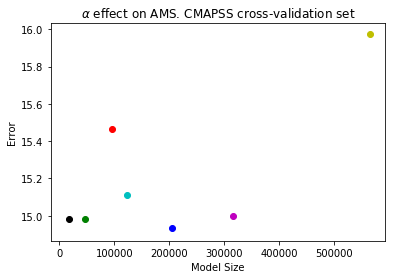

In [11]:
np_sizes = np.array(model_sizes)

#np_cv_errors = 1 - np.array(cv_errors) #Used for accuracy error

np_cv_errors = np.sqrt(np.array(cv_errors)) #Used for RMSE

np_alphas = np.array(alphas)

colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
n1 = plt.scatter(np_sizes[0], np_cv_errors[0], color = colors[0], label = 'alpha='+np_alphas[0])
n2 = plt.scatter(np_sizes[1], np_cv_errors[1], color = colors[1], label = 'alpha='+np_alphas[1])
n3 = plt.scatter(np_sizes[2], np_cv_errors[2], color = colors[2], label = 'alpha='+np_alphas[2])
n4 = plt.scatter(np_sizes[3], np_cv_errors[3], color = colors[3], label = 'alpha='+np_alphas[3])
n5 = plt.scatter(np_sizes[4], np_cv_errors[4], color = colors[4], label = 'alpha='+np_alphas[4])
n6 = plt.scatter(np_sizes[5], np_cv_errors[5], color = colors[5], label = 'alpha='+np_alphas[5]) 
n7 = plt.scatter(np_sizes[6], np_cv_errors[6], color = colors[6], label = 'alpha='+np_alphas[6])

#plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.xlabel('Model Size')
plt.ylabel('Error')

#plt.title(r'$\alpha$'+' effect on AMS. MNIST cross-validation set')
#plt.savefig('alpha_ams_mnist_cvset.png', bbox_inches='tight', dpi=300)

plt.title(r'$\alpha$'+' effect on AMS. CMAPSS cross-validation set')
plt.savefig('alpha_ams_cmapss_cvset.png', bbox_inches='tight', dpi=300)

plt.show()

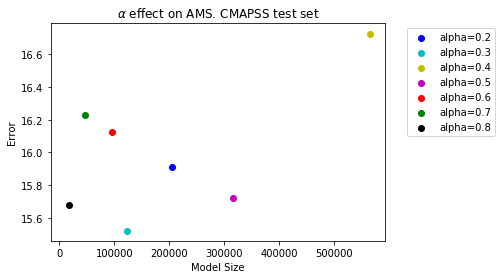

In [12]:
np_sizes = np.array(model_sizes)

#np_test_errors = 1 - np.array(test_errors) #Used for accuracy error

np_test_errors = np.sqrt(np.array(test_errors)) #Used for RMSE

np_alphas = np.array(alphas)

colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
n1 = plt.scatter(np_sizes[0], np_test_errors[0], color = colors[0], label = 'alpha='+np_alphas[0])
n2 = plt.scatter(np_sizes[1], np_test_errors[1], color = colors[1], label = 'alpha='+np_alphas[1])
n3 = plt.scatter(np_sizes[2], np_test_errors[2], color = colors[2], label = 'alpha='+np_alphas[2])
n4 = plt.scatter(np_sizes[3], np_test_errors[3], color = colors[3], label = 'alpha='+np_alphas[3])
n5 = plt.scatter(np_sizes[4], np_test_errors[4], color = colors[4], label = 'alpha='+np_alphas[4])
n6 = plt.scatter(np_sizes[5], np_test_errors[5], color = colors[5], label = 'alpha='+np_alphas[5]) 
n7 = plt.scatter(np_sizes[6], np_test_errors[6], color = colors[6], label = 'alpha='+np_alphas[6])

plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.xlabel('Model Size')
plt.ylabel('Error')

plt.title(r'$\alpha$'+' effect on AMS. MNIST test set')
plt.savefig('alpha_ams_mnist_testset.png', bbox_inches='tight', dpi=300)

plt.title(r'$\alpha$'+' effect on AMS. CMAPSS test set')
plt.savefig('alpha_ams_cmapss_testset.png', bbox_inches='tight', dpi=300)

plt.show()